In [1]:
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import manifold
from skimage.segmentation import mark_boundaries

sys.path.append('../aster-loader/')
from image import AsterImage
from plots import plot_embedding

## Individual Band Range Analysis
### Load data

In [2]:
aster = AsterImage('../../data/hiperespectral/pg-PR1B0000-2001022302_022_001.h5')

#### View band id information

In [3]:
aster.bands

{'SWIR': ['4', '5', '6', '7', '8', '9'],
 'TIR': ['10', '11', '12', '13', '14'],
 'VNIR': ['1', '2', '3N', '3B']}

In [4]:
swir_cube = aster.load_band_cube('SWIR')
vnir_cube = aster.load_band_cube('VNIR')
tir_cube  = aster.load_band_cube('TIR')

print(swir_cube.shape, vnir_cube.shape, tir_cube.shape)

(2100, 2490, 6) (4200, 4980, 3) (700, 830, 5)


In [5]:
flattened_swir_cube = aster.load_flat_cube('SWIR')
flattened_vnir_cube = aster.load_flat_cube('VNIR')
flattened_tir_cube  = aster.load_flat_cube('TIR')

print(flattened_swir_cube.shape, flattened_vnir_cube.shape, flattened_tir_cube.shape)

(5229000, 6) (20916000, 3) (581000, 5)


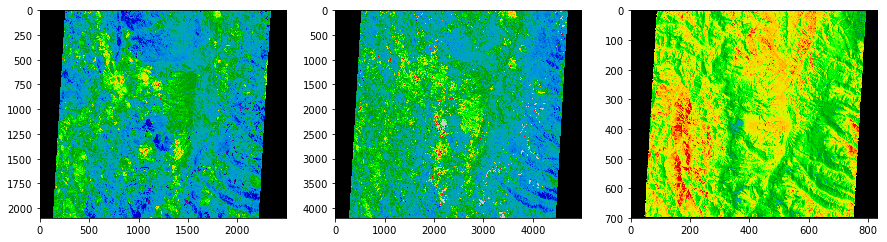

In [6]:
plt.figure(figsize=(15, 15))
color = plt.cm.spectral

plt.subplot(1, 3, 1)
plt.imshow(swir_cube[:, :, 0], cmap=color)

plt.subplot(1, 3, 2)
plt.imshow(vnir_cube[:, :, 0], cmap=color)

plt.subplot(1, 3, 3)
plt.imshow(tir_cube[:, :, 0], cmap=color)

### Get and plot 2D Manifolds

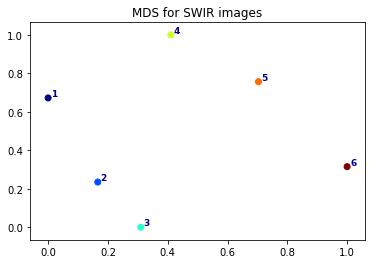

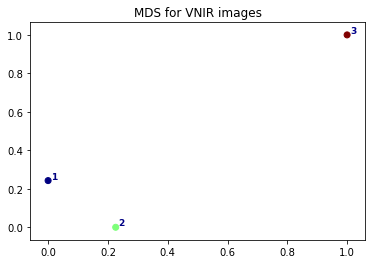

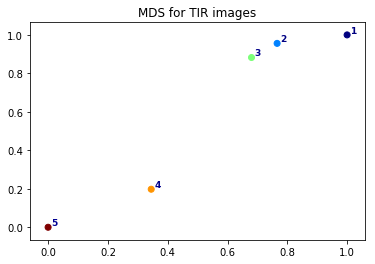

In [7]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
mds = manifold.MDS(n_components=2, max_iter=100, n_init=1)

cube_list = {
    'SWIR': flattened_swir_cube,
    'VNIR': flattened_vnir_cube,
    'TIR' : flattened_tir_cube,
}

for band_range, cube in cube_list.items():
    target = list(range(cube.shape[-1]))
    Y_mds = mds.fit_transform(cube.T)
    plot_embedding(Y_mds, cube.T, target, f'MDS for {band_range} images')

# Segmentation

## SEED Superpixels

Test for SEED superpixel over an entire band range (TIR in this case)

In [8]:
from cv2.ximgproc import createSuperpixelSEEDS

img = tir_cube

num_superpixels = 50
num_channels = img.shape[-1]
num_levels = 2

sp = createSuperpixelSEEDS(img.shape[1], img.shape[0], num_channels, num_superpixels, num_levels)

In [9]:
sp.iterate(img, 1000)
sp.getNumberOfSuperpixels()

30

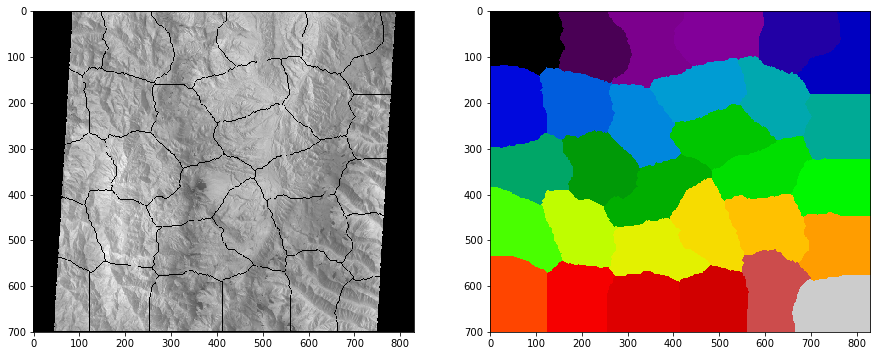

In [10]:
label_img  = sp.getLabels()
marked_img = mark_boundaries(img[:,:,0], label_img, mode='thick')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(marked_img[:,:,2], cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(label_img, cmap=plt.cm.spectral)

## All-bands analysis
### Resize dimensions to a common ground

In [11]:
print(swir_cube.shape, vnir_cube.shape, tir_cube.shape)

(2100, 2490, 6) (4200, 4980, 3) (700, 830, 5)


Band ranges have a linear scaling factor!

In [12]:
scale = 1
print(tir_cube.shape[0]*scale, tir_cube.shape[1]*scale)
scale = 3
print(tir_cube.shape[0]*scale, tir_cube.shape[1]*scale)
scale = 6
print(tir_cube.shape[0]*scale, tir_cube.shape[1]*scale)

700 830
2100 2490
4200 4980


We resize and verify that new shapes are the same as the base shape

In [13]:
from skimage.transform import resize
vnir_new_size = [tir_cube.shape[0], tir_cube.shape[1], vnir_cube.shape[2]]
swir_new_size = [tir_cube.shape[0], tir_cube.shape[1], swir_cube.shape[2]]

resized_tir_cube  = resize(tir_cube, tir_cube.shape, mode='constant')
resized_vnir_cube = resize(vnir_cube, vnir_new_size, mode='constant')
resized_swir_cube = resize(swir_cube, swir_new_size, mode='constant')

In [14]:
print(resized_tir_cube.shape,  resized_tir_cube.dtype,  f' max: {resized_tir_cube.max():.3f}' )
print(resized_vnir_cube.shape, resized_vnir_cube.dtype, f' max: {resized_vnir_cube.max():.3f}')
print(resized_swir_cube.shape, resized_swir_cube.dtype, f' max: {resized_swir_cube.max():.3f}')

(700, 830, 5) float64  max: 0.039
(700, 830, 3) float64  max: 1.000
(700, 830, 6) float64  max: 0.745


Finally, we append all into a single cube

In [15]:
full_cube = np.concatenate((resized_swir_cube, resized_vnir_cube, resized_tir_cube), axis=-1)
full_cube.shape

(700, 830, 14)

In [16]:
flattened_full_cube =  np.reshape(full_cube, (full_cube.shape[0]*full_cube.shape[1], full_cube.shape[2]))
flattened_full_cube.shape

(581000, 14)

# Manifold Learning

## T-SNE

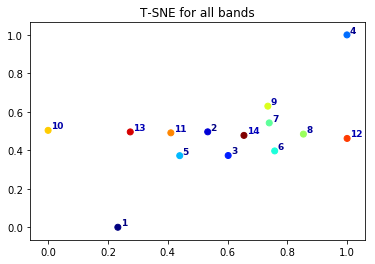

In [17]:
tsne   = manifold.TSNE(n_components=2, init='pca', random_state=0)
mds    = manifold.MDS(n_components=2, max_iter=100, n_init=1)
target = list(range(flattened_full_cube.shape[-1]))

Y_tsne  = tsne.fit_transform(flattened_full_cube.T)
plot_embedding(Y_tsne, flattened_full_cube.T, target, 'T-SNE for all bands')

**<span style="color:red"> ¿Tiene sentido normalizar en HSI? </span>**

# Segmentation

## SEED Superpixels

In [18]:
from cv2.ximgproc import createSuperpixelSEEDS

#VNIR
img = full_cube[:,:, 0:4].astype('float32')

num_superpixels = 30
num_channels = img.shape[-1]
num_levels = 1

sp = createSuperpixelSEEDS(img.shape[1], img.shape[0], num_channels, num_superpixels, num_levels)

In [19]:
sp.iterate(img, 100)
sp.getNumberOfSuperpixels()

25

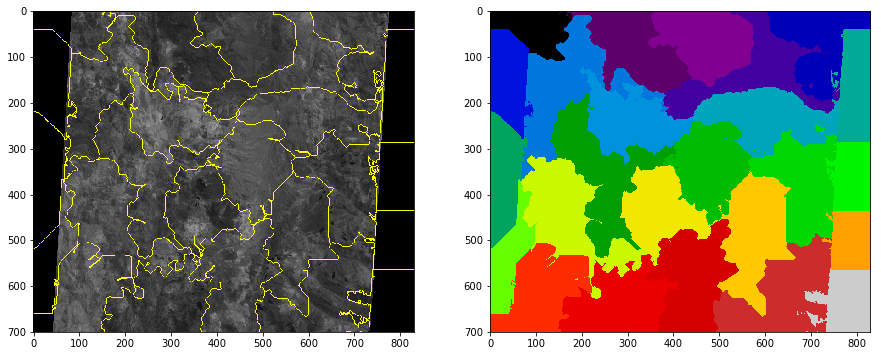

In [20]:
label_img  = sp.getLabels()
marked_img = mark_boundaries(img[:,:,0], label_img, mode='thick')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(marked_img, cmap=plt.cm.spectral)
plt.subplot(1, 2, 2)
plt.imshow(label_img, cmap=plt.cm.spectral)

In [21]:
plt.figure(figsize=(20, 20))
plt.imshow(marked_img, cmap=plt.cm.spectral)

# Clustering Spectra

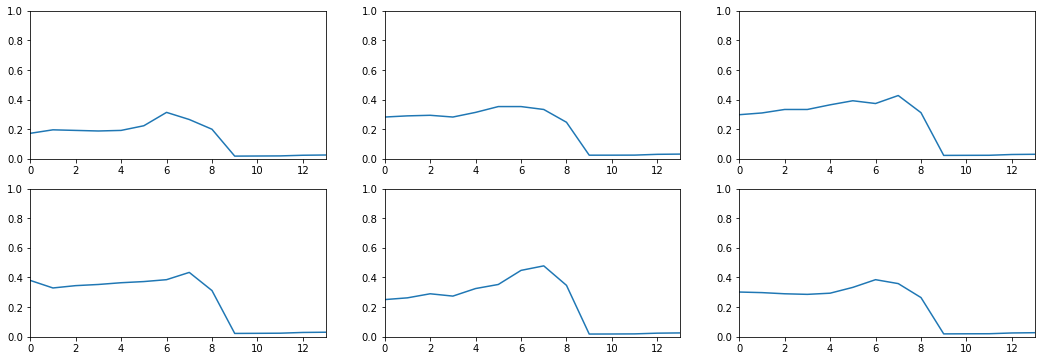

In [22]:
spectra = full_cube
plt.figure(figsize=(18, 6))

xy_list = [
    (200, 200),
    (300, 300),
    (200, 400),
    (400, 200),
    (600, 400),
    (400, 600)
]

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(spectra[xy_list[i][0], xy_list[i][1]])
    plt.ylim((0, 1))
    plt.xlim((0, 13))

    #plt.title(f"Pixel {pix}")
    #pix = pix + 1000

**Falta arreglar el tema del normalizado**, por ahora parece que lo mejor es simplemente utilizar cada rango de banda por separado.

## K-Means

In [23]:
from sklearn.cluster import KMeans

kmeans_params = {
    'n_clusters': 7,
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300,
    'tol': 0.0001,
    'precompute_distances': 'auto',
    'verbose': 0,
    'random_state': None,
    'n_jobs': 2,
    'algorithm': 'auto'
}

km = KMeans(**kmeans_params).fit(flattened_tir_cube)

In [24]:
print(km.labels_.shape)
print(len(np.unique(km.labels_)))

(581000,)
7


In [25]:
img_shape = tir_cube[:,:,0].shape
label_img = np.zeros(img_shape)

for i in range(len(km.labels_)):
    x, y = np.unravel_index(i, img_shape)
    label_img[x, y] = km.labels_[i]

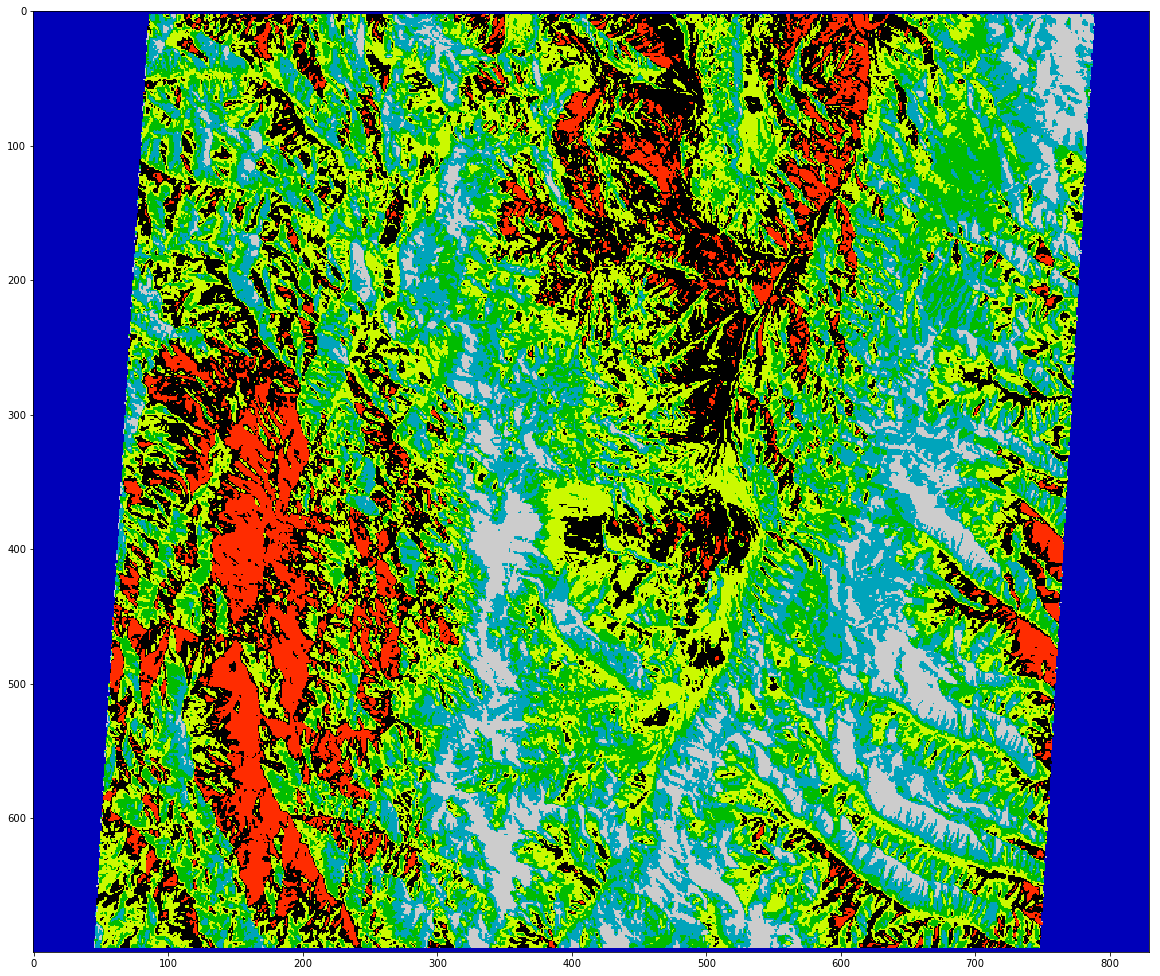

In [26]:
plt.figure(figsize=(20, 20))
plt.imshow(label_img, cmap=plt.cm.spectral)

## DBScan

In [27]:
# stop here, DBScan and Spectral Clustering run out of memory
assert 0 == 1

AssertionError: 

In [ ]:
from sklearn.cluster import DBSCAN

dbscan_params = {
    'eps': 5.,
    'min_samples': 10,
    'metric': 'euclidean',
    'algorithm': 'auto',
    'leaf_size': 30,
    'n_jobs': 2
}

db = DBSCAN(**dbscan_params).fit(flattened_tir_cube)

In [ ]:
print(db.labels_.shape)
print(len(np.unique(db.labels_)))

## Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

spectral_params = {
    'n_clusters': 10,
    'eigen_solver': None,
    'random_state': None,
    'n_init': 10,
    'gamma': 1.0,
    'affinity': 'rbf',
    'n_neighbors': 10,
    'eigen_tol': 0.0,
    'assign_labels': 'kmeans',
    'degree': 3,
    'coef0': 1,
    'kernel_params': None,
    'n_jobs': 2
}

sc = SpectralClustering(**spectral_params).fit(flattened_tir_cube)